# postISR corner WFS: debug WCS with arrow stars, bscDbType:file, close AOS loop

A notebook to show the diffence in using `WcsSol` vs `PhosimWcsSol`. 

The latter is not compatible with `skySim` WCS. 

I use arrows simulated on corner wavefront sensors using `skySim`, and show how the results of PhoSim simulation get passed to `ts_wep`


NB: We have to change the `bscDbType` manually before initializing `wep_calc`, because once `WEPCalculationFactory` is called, `updateSetting` won't do anything for `bscDbType` - because by then the sourceSelector had already been configured. The same with `expWcs`, since it's in the `__init` method of the `SourceSelector`. Other settings can be changed later , but before they are checked by the code . 

In [104]:
import os
import argparse
import numpy as np

from lsst.utils import getPackageDir
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.Utility import CamType, FilterType, getModulePath, mapFilterRefToG, DefocalType
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

#parts of analysis_tools/runCloseLoopPostISR.py
save_postage_stamps=True 
run_deblender=False
select_sensor = 'lsstcam' 
rerun='run1'
db_filename = 'bsc1.db3'
gaia_field_name=''
rotAngInDeg = 0
bscDbType='file'
setting_filename = 'default.yaml'
raInDeg=0
decInDeg=0


# updating bscDbType manually 
path_to_ts_wep = getPackageDir("ts_wep")
path_to_setting_file = os.path.join(path_to_ts_wep, 'policy',setting_filename)
settingFile = ParamReader(filePath=path_to_setting_file)
bscDbTypeInFile = settingFile.getSetting("bscDbType")
print('%s contains : '%path_to_setting_file, 
      bscDbTypeInFile)
if bscDbTypeInFile != bscDbType:
    # In the following we update the setting for bscDbType,
    # saving the change in the default.yaml file 
    settingFile.updateSetting("bscDbType", bscDbType)
    settingFile.saveSetting(filePath=path_to_setting_file)

    # check that the change indeed took place 
    settingFile = ParamReader(filePath=path_to_setting_file)
    print('After change: ', settingFile.getSetting("bscDbType"))

bscDataDir = os.path.join(path_to_ts_wep, 'tests/testData')
if db_filename  in os.listdir(bscDataDir):
    os.remove(os.path.join(bscDataDir,db_filename))
    print('Removed old %s file'%db_filename)
    



/astro/store/epyc/users/suberlak/Commissioning/aos/ts_wep/policy/default.yaml contains :  file
Removed old bsc1.db3 file


In [105]:
# update expWcs setting ... 
expWcs = False # using PhoSim WCS Sol 
settingFile= ParamReader(filePath=path_to_setting_file)
settingFile.updateSetting("expWcs", expWcs)
settingFile.saveSetting(filePath=path_to_setting_file)
settingFile = ParamReader(filePath=path_to_setting_file)
print('After change: expWcs : ', settingFile.getSetting("expWcs"))



########################
# Initialize wep_calc
########################
print('select_sensor is %s'%select_sensor)
if select_sensor == 'comcam':
    wep_calc = WEPCalculationFactory.getCalculator(CamType.ComCam, closed_loop_input_dir)
elif select_sensor  == 'lsstcam':
    wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, closed_loop_input_dir)
elif select_sensor == 'lsstfamcam':
    wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstFamCam, closed_loop_input_dir)

    

After change: expWcs :  False
select_sensor is lsstcam


In [249]:
(9 / 4) * 3

6.75

In [106]:
# this is only executed once 
# wep_calc._getTargetStar() is called 
#settingFile = wep_calc.getSettingFile()
dbRelativePath = 'tests/testData/%s'%db_filename
wep_calc.settingFile.updateSetting("defaultBscPath", dbRelativePath)

# if GAIA field name is not provided, we assume raInDeg, decInDeg as boresight 
print('\nSetting telescope boresight as (%.2f, %.2f)'%(raInDeg,decInDeg))
wep_calc.setBoresight(raInDeg, decInDeg)

print('\nSetting telescope rotation angle as %.2f'%rotAngInDeg)
wep_calc.setRotAng(rotAngInDeg)

# Set the output directory :   iter0/pert
outputDirName = "pert"
# set the sky file 
skyInfoFileName = 'skyLsstCamInfo.txt'
baseOutputDir = topDir
# the iteration directory 
iterCount = 0
iterDirName = "%s%d" % ("iter", iterCount)
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
outputSkyInfoFilePath = os.path.join(outputDir, skyInfoFileName)
print('Setting sky file as %s'%outputSkyInfoFilePath)
wep_calc.setSkyFile(outputSkyInfoFilePath)


# this is already part of 
# listOfWfErr = wepCalc.calculateWavefrontErrors(
#                 intraRawExpData, postageImg=postageImg, postageImgDir = postageImgDir,
#                 sensorNameToIdFileName=sensorNameToIdFileName)
postISRdir = os.path.join(closed_loop_input_dir, 'rerun/%s'%rerun)
print('Setting postISR CCD inputs as %s'%postISRdir)

wep_calc.wepCntlr.setPostIsrCcdInputs(postISRdir)
intraObsId = 9006002
extraObsId = 9006001
if select_sensor in ['lsstfamcam','comcam']:
    obsIdList = [intraObsId, extraObsId]
elif (select_sensor == 'lsstcam'):
    obsIdList = [intraObsId]
    



Setting telescope boresight as (0.00, 0.00)

Setting telescope rotation angle as 0.00
Setting sky file as /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/iter0/pert/skyLsstCamInfo.txt
Setting postISR CCD inputs as /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/input/rerun/run1


In [107]:
################################
# begin wep_calc._getTargetStar()

from lsst.ts.wep.Utility import getModulePath, getConfigDir, BscDbType, \
    FilterType, abbrevDetectorName, getBscDbType, getImageType, \
    getCentroidFindType, ImageType, DefocalType
    

# Now inside WEPCalculation.py, 
# Get the target stars map neighboring stars
#         neighborStarMap = self._getTargetStar(intraObsIdList,
#                                               DefocalType.Intra,
#                                               lowMagnitude, highMagnitude)


# inside _getTargetStar()
# we select the appropriate method to query the database 

sourSelc = wep_calc.wepCntlr.getSourSelc()
bscDbType = wep_calc._getBscDbType()

if bscDbType in (BscDbType.LocalDb, BscDbType.LocalDbForStarFile,
                         BscDbType.LocalDbFromImage, BscDbType.LocalDbFromRefCat):
    dbRelativePath = wep_calc.settingFile.getSetting("defaultBscPath")
    dbAdress = os.path.join(getModulePath(), dbRelativePath)
    sourSelc.connect(dbAdress)
sourSelc.setObsMetaData(wep_calc.raInDeg, wep_calc.decInDeg, 
                        wep_calc.rotSkyPos)
camDimOffset = wep_calc.settingFile.getSetting("camDimOffset")
skyFile = wep_calc._assignSkyFile()
print('The skyFile is %s'%skyFile)


The skyFile is /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/iter0/pert/skyLsstCamInfo.txt


In [108]:
from lsst.ts.wep.ctrlIntf.PhosimWcsSol import PhosimWcsSol
# Now get inside 
# neighborStarMap = sourSelc.getTargetStarByFile(skyFile, visitList, 
# offset=camDimOffset)[0]
# Get inside SourceSelector.py
# to dissect `sourSelc.getTargetStarByFile()`:
visitList = obsIdList
filterType = sourSelc.getFilter()
mappedFilterType = mapFilterRefToG(filterType)
if type(sourSelc.camera._wcs) == PhosimWcsSol:
    print('Using PhosimWcsSol')
    sourSelc.camera._wcs.setWcsDataFromIsrDir(mappedFilterType,
                                                sourSelc.camera.getWfsCcdList(),
                                            visitList[0])
else:
    print('Using ', sourSelc.camera._wcs)
    
skyFilePath = skyFile 
sourSelc.db.createTable(mappedFilterType)
sourSelc.db.insertDataByFile(skyFilePath, mappedFilterType, skiprows=1)

Using  <lsst.ts.wep.bsc.WcsSol.WcsSol object at 0x7f5cb64f0190>


In [110]:
offset  = camDimOffset
neighborStarMap, starMap, wavefrontSensors = sourSelc.getTargetStar(offset=offset)

In [113]:
neighborStarMap['R:0,0 S:2,2,A'].getRaDecl()

{48: (358.792385, -1.185693),
 49: (358.792393, -1.169047),
 50: (358.792401, -1.1524),
 62: (358.786854, -1.130204),
 51: (358.792409, -1.135753),
 52: (358.731291, -1.124657),
 53: (358.74796, -1.124657),
 54: (358.76463, -1.124656),
 55: (358.7813, -1.124655),
 56: (358.720149, -1.196787),
 57: (358.731265, -1.185692),
 58: (358.742381, -1.174596),
 59: (358.753499, -1.163499),
 60: (358.764617, -1.152401),
 61: (358.775735, -1.141303),
 63: (358.792414, -1.124654)}

The next step would be to do 
    
    neighborStarMap, starMap, wavefrontSensors = self.getTargetStar(offset=offset)

where the following is done 

    wavefrontSensors = self.camera.getWavefrontSensor()
    lowMagnitude, highMagnitude = self.filter.getMagBoundary()

    # Query the star database
    starMap = dict()
    neighborStarMap = dict()
    for detector, wavefrontSensor in wavefrontSensors.items():

        # Get stars in this wavefront sensor for this observation field
        stars = self.db.query(mappedFilterType, wavefrontSensor[0],
                              wavefrontSensor[1], wavefrontSensor[2],
                              wavefrontSensor[3])

So I first check the location of each sensor as encoded in `camera.getWavefrontSensor()`

R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


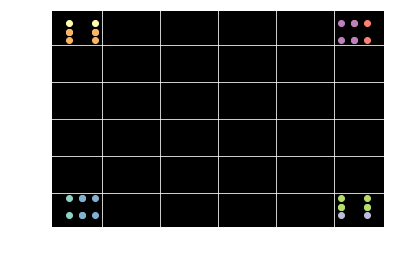

In [79]:
%matplotlib inline

fig,ax = plt.subplots(1,1,)
#thes coords are center of each sensor 
wavefrontSensors= sourSelc.camera.getWavefrontSensor()
for detector, wavefrontSensor in wavefrontSensors.items():
    print(detector)#, wavefrontSensor)  
 
    corner1 = wavefrontSensor[0]
    corner2 = wavefrontSensor[1]
    corner3 = wavefrontSensor[2]
    corner4 = wavefrontSensor[3]
    ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
    decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])
    
    # switch from (0,360) to (-180,180) 
    # just for plotting 
    m = ra>180
    ra[m] = ra[m] - 360
    #print(ra)
    #print(decl)
    ax.scatter(ra,decl)
ax.set_xlabel('Ra [deg]')
ax.set_xlabel('Decl [deg]')
ax.grid()

Compare that to the information in sky file. First, plot the perceived detector boundaries atop the skyFile : those are the boundaries used to query the database  

Text(0, 0.5, 'Decl')

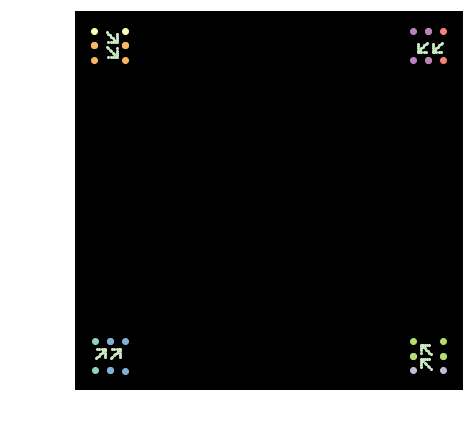

In [80]:
skyInfo = np.loadtxt(skyFilePath,skiprows=1)

skyStarId = skyInfo[:,0] ; skyRa = skyInfo[:,1] ; skyDecl = skyInfo[:,2] ; skyMag =skyInfo[:,3]


fig,ax = plt.subplots(1,1,figsize=(7,7))

#the coords are center of each sensor from 
# sourSelc.camera.getWavefrontSensor()
wavefrontSensors= sourSelc.camera.getWavefrontSensor()
for detector, wavefrontSensor in wavefrontSensors.items():
    #print(detector)#, wavefrontSensor)  
 
    corner1 = wavefrontSensor[0]
    corner2 = wavefrontSensor[1]
    corner3 = wavefrontSensor[2]
    corner4 = wavefrontSensor[3]
    ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
    decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])
    m = ra>180
    ra[m] = ra[m] - 360
    #print(ra)
    #print(decl)
    ax.scatter(ra,decl)
skyRaShifted = skyRa.copy()
mask = skyRa > 180
skyRaShifted[mask] = skyRaShifted[mask]-360
ax.scatter(skyRaShifted, skyDecl,s=4)
ax.set_xlabel('RA')
ax.set_ylabel('Decl')


They're off when using `PhosimWcsSol` !   In fact, show the result of querying the star database  for `R:0,4 S:2,0,A` , plotting the stars.getRA , stars.getDecl atop the input star catalog , showing which stars get selected based on the detector boundaries : 

In [89]:
wavefrontSensors= sourSelc.camera.getWavefrontSensor()
detectorList = list(wavefrontSensors.keys())

Using detector R:0,4 S:2,0,A


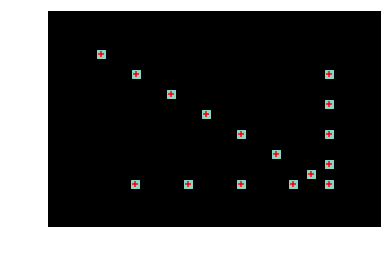

In [96]:
# Query the star database
starMap = dict()
neighborStarMap = dict()

# do it for a second set of stars ... 
#for detector, wavefrontSensor in wavefrontSensors.items():

detector = detectorList[1]
print('Using detector %s'%detector)
wavefrontSensor = wavefrontSensors[detector]

# Get stars in this wavefront sensor for this observation field
stars = sourSelc.db.query(mappedFilterType, wavefrontSensor[0],
                          wavefrontSensor[1], wavefrontSensor[2],
                          wavefrontSensor[3])

# the database is filled with LocalDatabaseForStarFile.insertDataByFile
# it is queried with DefaultDatabase.query that passes to 
# LocalDatabase._queryTable

# for one sensor only, as selected above 
corner1=wavefrontSensor[0]
corner2=wavefrontSensor[1]
corner3=wavefrontSensor[2]
corner4=wavefrontSensor[3]
ra = [corner1[0], corner2[0], corner3[0], corner4[0]]
decl = [corner1[1], corner2[1], corner3[1], corner4[1]]
top = max(decl)
bottom = min(decl)
left = min(ra)
right = max(ra)

# same as 
#  command = "SELECT simobjid, ra, decl, " + \
#       filterType.name.lower() + "mag" + \
#       " FROM " + tableName + \
#       " WHERE decl <= %f AND decl >= %f AND ra >= %f AND ra <= %f"
m = (skyDecl <= top) *(skyDecl >= bottom)*(skyRa >= left) *(skyRa <= right) 

# just for plotting 
# mask = skyRa > 180
# skyRaShifted = skyRa.copy()
# skyRaShifted[mask] = skyRaShifted[mask]-360
plt.scatter(skyRa[m], skyDecl[m], marker='s', s=65)
plt.scatter(stars.getRA(),stars.getDecl(),marker='+',c='r')

So the problem is that not all the stars get selected...

Show how I got the arrow stars (ra,dec) coordinates using SkySim : 

In [71]:
from lsst.ts.phosim.SkySim import SkySim
import sys
sys.path.append('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_tools/')
import analysisTools as at

mjd = 57648  # arbitrary observation date 
raInDeg = 0 # telescope pointing in degrees 
declInDeg = 0
rotSkyPos = 0 # rotation angle in degrees 
starMag = 15 # star magnitude 

# Declare the SkySim()
skySim = SkySim()

# Set the observation information
skySim.setObservationMetaData(raInDeg, declInDeg, rotSkyPos, mjd)

sensorName = ["R44_S00_C0", "R00_S22_C0",
              "R40_S02_C0", "R04_S20_C0",
              "R44_S00_C1", "R00_S22_C1",
              "R40_S02_C1", "R04_S20_C1",
             ]

# add arrows  per half-sensor 
xPx, yPx = at.pixel_arrow(x_vertex=1500, y_vertex=3000, width=1100, 
                spacing=300, diag_spacing=200, xmin=0, xmax=2000,
                ymin=0, ymax=4072, xy_offset=1300, print_shape=False )


from astropy.table import Table
store_x = []
store_y = []
store_sen = [] 
imType = []

starId = 0 
for sensor in sensorName:
    for i in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[i],
                                yPx[i], starMag)
        store_x.append(xPx[i])
        store_y.append(yPx[i])
        store_sen.append(sensor)
        imType.append('arrow')
        starId += 1 
        
# add outlines per half-sensor ... 
xPx, yPx = at.pixel_outline(xmin=0,  xmax=2000, ymin=0, 
                            ymax=4072,print_shape=False)
 
for sensor in sensorName:
    for i in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[i],
                                yPx[i], starMag)
        store_x.append(xPx[i])
        store_y.append(yPx[i])
        store_sen.append(sensor)
        imType.append('outline')
        starId += 1 
        
ra,dec = skySim.getRaDecInDeg()

coords_wfs = Table(data=[ra,dec, store_x,store_y, store_sen, imType], 
             names=['ra','dec', 'xPx', 'yPx', 'sensorName', 'imType']  )


# shift just for plotting 
m = coords_wfs['ra']>180
coords_wfs['ra'][m]  = coords_wfs['ra'][m]-360



[1500 1500 1500 1500] [1900 2200 2500 2800]
[ 400  700 1000 1300] [3000 3000 3000 3000]
y=1.00x 1500.00
[ 200  400  600  800 1000 1200 1400] [1700. 1900. 2100. 2300. 2500. 2700. 2900.]
[1500. 1500. 1500. 1500.  400.  700. 1000. 1300.  200.  400.  600.  800.
 1000. 1200. 1400. 1500.] [1900. 2200. 2500. 2800. 3000. 3000. 3000. 3000. 1700. 1900. 2100. 2300.
 2500. 2700. 2900. 3000.]


Plot the SkySim detector outlines as well as arrows, on top of the `sourSelc.camera.getWavefrontSensor` detector boundaries :

R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


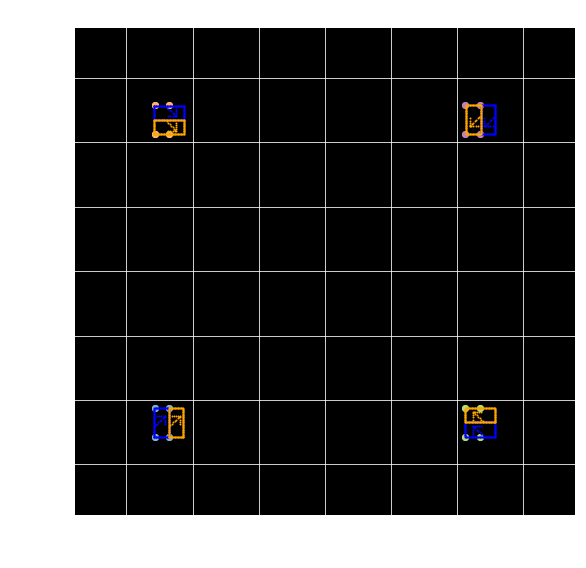

In [73]:
fig,ax = plt.subplots(1,1,figsize=(9,9))
lim = 1.9


wavefrontSensors= sourSelc.camera.getWavefrontSensor()
for detector, wavefrontSensor in wavefrontSensors.items():
    print(detector)#, wavefrontSensor)  
 
    corner1 = wavefrontSensor[0]
    corner2 = wavefrontSensor[1]
    corner3 = wavefrontSensor[2]
    corner4 = wavefrontSensor[3]
    ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
    decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])
    m = ra>180
    ra[m] = ra[m] - 360
    #print(ra)
    #print(decl)
    ax.scatter(ra,decl)
    


# plot WFS (LsstCam)
for part,color in zip(['C0','C1'], ['blue','orange']):
    m = [s.endswith(part) for s in coords_wfs['sensorName']]
    ax.scatter(coords_wfs['ra'][m], coords_wfs['dec'][m],c=color,s=1)
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    

ax.set_xlabel('RA')
ax.set_ylabel('Decl')

ax.grid()
if expWcs :
    title  = "Phosim"
else:
    title = ""
plt.title('SkySim (arrows)  vs %sWcsSol (thick dots)'%title)
plt.savefig('SkySim_corner_sensors_%sWcsSol.png'%title,bbox_inches='tight')


Next: show the actual neighborStarMap , which is the result of 

    
    neighborStarMap = sourSelc.getTargetStarByFile(skyFile, visitList, offset=camDimOffset)[0]
    
i.e. 

     if (not type(self.db) == LocalDatabaseForStarFile):
            errorString = "The database type is incorrect."
            errorString += " Received type: {} but expected type: {}".format(
                type(self.db),LocalDatabaseForStarFile)
            raise TypeError(errorString)

        # Map the reference filter to the G filter
        filterType = self.getFilter()
        mappedFilterType = mapFilterRefToG(filterType)

        if type(self.camera._wcs) == PhosimWcsSol:
            self.camera._wcs.setWcsDataFromIsrDir(mappedFilterType,
                                                  self.camera.getWfsCcdList(),
                                                  visitList[0])

        # Write the sky data into the temporary table
        self.db.createTable(mappedFilterType)
        self.db.insertDataByFile(skyFilePath, mappedFilterType, skiprows=1)
        
which I executed above, and then 

     neighborStarMap, starMap, wavefrontSensors = self.getTargetStar(offset=offset)

        # Delete the table
        self.db.deleteTable(mappedFilterType)
        
which I execute below : 

In [99]:
offset = camDimOffset
neighborStarMap, starMap, wavefrontSensors = sourSelc.getTargetStar(offset=offset)
#sourSelc.db.deleteTable(mappedFilterType)  : last step in SourceSelector.py

#sourSelc.disconnect()  : last step in wep_calc._getTargetStar()

In [119]:
# now this happens in wep_calc._calcWfErr : 
detector_list = list(neighborStarMap)
isrImgMap = wep_calc.wepCntlr.getPostIsrImgMapOnCornerWfs(detector_list, obsIdList[0])

R:0,0 S:2,2,A is intra-focal
R:0,4 S:2,0,A is intra-focal
R:4,0 S:0,2,A is intra-focal
R:4,4 S:0,0,A is intra-focal
R:0,0 S:2,2,B is extra-focal
R:0,4 S:2,0,B is extra-focal
R:4,0 S:0,2,B is extra-focal
R:4,4 S:0,0,B is extra-focal


In [ ]:
# then we go to get donut map from WepController.py : 
# donutMap = self.wepCntlr.getDonutMap(
#             neighborStarMap, wfsImgMap, self.getFilter(),
#             doDeblending=doDeblending, postageImg=postageImg,
#             postageImgDir=postageImgDir)

Display the stars in neighborStarMap atop the postISR images: 

In [ ]:
detect

Plotting for sensor R:0,0 S:2,2,B 


Text(0.5, 1.0, 'R:0,0 S:2,2,B')

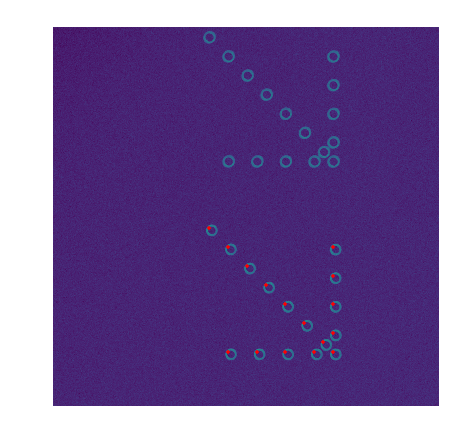

In [144]:
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(7,7))
sensor  = 'R:0,0 S:2,2,B'# detector_list[0]
print('Plotting for sensor %s '%sensor)

if sensor.endswith('A'):
    image = np.flipud(isrImgMap[sensor].getIntraImg().T)
elif sensor.endswith('B'):
    image = np.flipud(isrImgMap[sensor].getExtraImg().T)
ax.imshow(image, vmax=1200, origin='lower')

xyPxStarCoord = neighborStarMap[sensor].getRaDeclInPixel()
for starId in xyPxStarCoord.keys():
    xy = xyPxStarCoord[starId]
    ax.scatter(xy[0],xy[1],marker='+',c='r',s=20)
ax.set_title(sensor)
# for donut in donut_map[sensor]:
#     ax.scatter(donut.pixelY, donut.pixelX, marker='d', c='w')

Aha, perhaps the xy coords in there refer to coords WITHIN each half-sensor! That would make sense, since they are treated independently, i.e. each has dimensions (0,4071,0,2000)

Because the starId's (taken from the input star catalog) ARE DIFFERENT for neighborStarMap for each half-sensor. That means that they are being picked up :

In [149]:
neighborStarMap['R:0,0 S:2,2,B'].getId()

{16: [],
 17: [],
 18: [],
 19: [30],
 20: [],
 21: [],
 22: [],
 23: [30],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 31: [30]}

In [150]:
neighborStarMap['R:0,0 S:2,2,A'].getId()

{48: [],
 49: [],
 50: [],
 51: [62],
 52: [],
 53: [],
 54: [],
 55: [62],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 63: [62]}

But why do I need to flip the detector image up-down and transpose for the neighborStarMap px coordinates make sense ? I'm not sure , but it applies to all detectors ... And I'm using  `2020_24`   , which is before the `2020_34` update to `lsst_obs` by RHL, but I thought I checked that the orientation of images as made by `phosim_repackager.py` didn't change.. Or so I thought ! If there are problems at that stage, try to make an `lsst_phosim_2020_36` kernel  that uses the most recent weekly ... 

In [153]:
donut_map = wep_calc.wepCntlr.getDonutMap(neighborStarMap, isrImgMap, FilterType.REF,
                                          doDeblending=run_deblender, postageImg=save_postage_stamps,
                                          postageImgDir=postage_img_dir, verbose=False)


 Calculating the donut map 
Saving postage stamp images in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/postage


Plot all the donuts reported for each sensor : 

In [156]:
sensors = list(donut_map.keys())

In [163]:
from lsst.ts.wep.Utility import abbrevDetectorName, parseAbbrevDetectorName

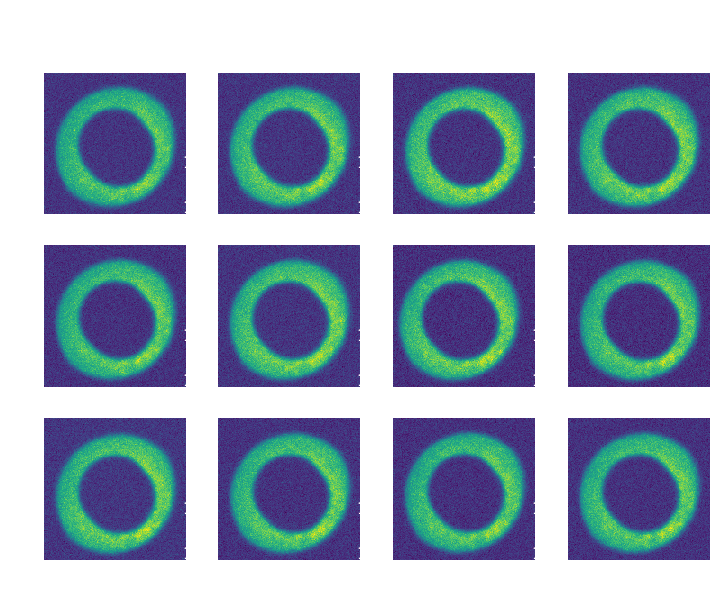

In [170]:
sensor = sensors[4]#'R:0,0 S:2,2,A'

Ndonuts = len(donut_map[sensor])
Ncol = 4
# if there is no remainder 
Nrow = Ndonuts // Ncol # integer division , eg. 18 // 4  = 4
# if remainder in division, add extra row , eg. 18 % 4 = 2 
if Ndonuts % Ncol > 0 : 
    Nrow += 1 
fig,axs = plt.subplots(Nrow,Ncol,figsize=(Ncol*3,Nrow*3))
ax = np.ravel(axs)

i = 0 
sensorName = '%s ,'%sensor
for donut in donut_map[sensor]:
    if sensor.endswith('A'):
        ax[i].imshow(donut.getIntraImg())
        focal ='intra-focal'
    elif sensor.endswith('B'):
        ax[i].imshow(donut.getExtraImg())
        focal ='extra-focal'
    i += 1
fig.suptitle(sensorName+' ' +focal, fontsize=20)
fname = 'wfs_arrows_%s_%s.png'%(abbrevDetectorName(sensor),focal)
plt.savefig(fname, dpi=100, bbox_inches='tight')

So now proceed to the `donutMap = wep_calc.wepCntlr.calcWfErr(donut_map, postage_img_dir)`. Just note that at this stage for ComCam `donut_map` has 9 detectors, and for each  `donut_map[0][donutNumber].getIntraImg()` and `getExtraImg()`, while for LsstCam, it has 8 half-detectors (4 full detectors), and for the `A` ones `donut_map` has only `getIntraImg` and for `B` it only has `getExtraImg`. The overall content is the same (Ndonuts = Ndetectors*2), but packaged differently. That's why `calcWfErr` obtaines the `intra` and `extra` donuts in a different way if detector name ends with `A` or `B` : 

In [173]:
donutMap = wep_calc.wepCntlr.calcWfErr(donut_map, postage_img_dir)


 Calculating the wavefront error based on the donut map

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 48  donut px pos =  (1417.065542538117, 1847.370183357313)

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 49  donut px pos =  (1417.9788434448717, 2147.333003809669)

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 50  donut px pos =  (1418.0536032427392, 2448.3721876193895)

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 52  donut px pos =  (316.09219661906286, 2946.385227594431)

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 53  donut px pos =  (617.0594848046582, 2947.3314905668194)

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 54  donut px pos =  (917.9915690947264, 2947.396249495072)

 sensorName  R:0,0 S:2,2,A  abbrevDetectorName  R00_S22_C0  starId= 56  donut px pos =  (124.97298354144682, 1645.4538181008484)

 sensorName  R:0,0 S:2,2,A  abbrevDetec

In [182]:
intra = donutMap['R:0,0 S:2,2,A'][0].getWfErr()
extra = donutMap['R:0,0 S:2,2,B'][0].getWfErr()
intra-extra

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [206]:
intra = donutMap['R:4,4 S:0,0,A'][0].getWfErr()
extra = donutMap['R:4,4 S:0,0,B'][0].getWfErr()
intra-extra

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [184]:
intra-donutMap['R:4,4 S:0,0,A'][0].getWfErr()

array([ -10.30503475,   49.0559141 ,   13.18974743,  169.65531089,
        -45.52394999,  186.27774337, -144.0618047 ,   -1.97186537,
         -4.55198352,   -5.49783188,    0.22710776,   11.00465833,
         60.50433696,    8.24625215,   -1.37385035,    4.37631959,
        -15.84448467,   -4.12075667,   -0.3053496 ])

In [295]:
a = 'aab..B'
a.endswith(('A','B'))

True

In [ ]:
list(donutMap.keys())[0].endswith

In [296]:
if list(donutMap.keys())[0].endswith(('A','B')):
    print('a')

a


Ok, so basically the content of donutMap here is the same for intra/extra half-sensors (which it should be !). But now perhaps need to pass just a list of four sensors, since we have a list of wavefront errors unique to each pair of corner sensors. 

In [212]:
# I just make a new dictionary, and since I know from above that 
# error for R:0,0 S:2,2,A is the same as for R:0,0 S:2,2,B,
# I keep just one of these 
donutMapAbbrev  = {}
detectors = list(donutMap.keys())

for detector in detectors:
    raft,sensor = parseAbbrevDetectorName(abbrevDetectorName(detector))
    detect = '%s_%s'%(raft,sensor)
    
    donutMapAbbrev[detector[:-2]] = donutMap[detector]

In [214]:
donutMapAbbrev.keys()

dict_keys(['R:0,0 S:2,2', 'R:0,4 S:2,0', 'R:4,0 S:0,2', 'R:4,4 S:0,0'])

For the next step, I think I want the listOfWfErr to have 4 elements, one per each corner sensor (since each half-sensor has exactly the same data above)

In [213]:
listOfWfErr = wep_calc._populateListOfSensorWavefrontData(donutMapAbbrev, )
#                      sensorNameToIdFileName='sensorNameToIdWfs.yaml')


In [306]:
listOfWfErr[0].getSensorId()

2

In [224]:
# Now we save the wavefront error to a file in the same 
# order as OPD 
# parts of 
#phosimCmpt.reorderAndSaveWfErrFile(listOfWfErr, sensorNameList,
#                                           zkFileName=wfsZkFileName)

wfs_zer_output= 'wfs.arrow.zer'
zerDict = {}
for wfErrObj in listOfWfErr:
    zerDict[wfErrObj.getSensorId()] = wfErrObj.getAnnularZernikePoly()

sensorKeys = list(zerDict.keys())
sensorKeys.sort()

zerList = []
for sensorKey in sensorKeys:
    zerList.append(zerDict[sensorKey])
    
zerArray = np.array(zerList)

wfs_output_path = os.path.join(closed_loop_input_dir, wfs_zer_output)
print('\nSaving the list of wavefront errors as %s'%wfs_output_path)
np.savetxt( wfs_output_path , zerArray, header='The following are ZK in um from z4 to z22:')


Saving the list of wavefront errors as /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/input/wfs.arrow.zer


In [230]:
donutMao = donutMap.copy()

## OFC part

In [244]:
from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory
from lsst.ts.wep.ctrlIntf.MapSensorNameAndId import MapSensorNameAndId
ofcCalc = OFCCalculationFactory.getCalculator(InstName.LSST)
ofcCalc.setFilter(FilterType.REF)
ofcCalc.setRotAng(rotAngInDeg)
ofcCalc.setGainByPSSN()

# Set the FWHM data: inside
# listOfFWHMSensorData = phosimCmpt.getListOfFwhmSensorData(opdPssnFileName, sensorNameList)
opdPssnFileName = "PSSN.txt" # it has shape 2,32, 
# because it has OPD at 31 locations for the LsstFamCam 
# output of _getWfsSensorNameList()
#sensorNameList = ["R00_S22","R04_S20","R44_S00","R40_S02"]


# from PhosimCmpt._getDataOfPssnFile()
pssnFileName = opdPssnFileName
outputImgDir  = os.path.join(baseOutputDir, 'iter0','img')
filePath = os.path.join(outputImgDir, pssnFileName)
data = np.loadtxt(filePath)
fwhmData = data[1, :-1]

# sensorNameToIdFileName  = 'sensorNameToIdWfs.yaml'
# mapSensorNameAndId = MapSensorNameAndId(sensorNameToIdFileName)

In [245]:
filePath

'/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/iter0/img/PSSN.txt'

Now we provide a list of all sensors in LsstFamCam since that's what OPD was evaluated for, but only at 31 locations. Thus need to pick 31 sensors which correspond to these OPD locations.

In [297]:
# this provides 
def _getLsstFamCamSensorNameList():
    # I assume it includes the ComCam 
    chips  = ['00','01','02',
              '10','11','12',
              '20','21','22']
    rafts = ['14','24','34', 
        '03','13','23','33','43',
        '02','12','22','32','42',
        '01','11','21','31','41',
             '10','20','30']
    sensors = []
    for r in rafts:
        for c in chips:
            s = "R%s_S%s"%(r,c)
            sensors.append(s)
    sensorNameList = sensors
    return sensorNameList
    
refSensorNameList = _getLsstFamCamSensorNameList()
sensorNameToIdFileName  = 'sensorNameToId.yaml'
mapSensorNameAndId = MapSensorNameAndId(sensorNameToIdFileName)

from lsst.ts.wep.ParamReader import ParamReader

path_to_ts_ofc = getPackageDir("ts_ofc")
mappingFilePath = os.path.join(path_to_ts_ofc , 'policy/lsst', 'sensorNameToFieldIdx.yaml')
_mappingFile = ParamReader()
_mappingFile.setFilePath(mappingFilePath)

fieldIdx = []
for sensor in refSensorNameList:
    field = _mappingFile.getSetting(sensor)
    fieldIdx.append(int(field))
    
uniqueFieldIdx = np.unique(fieldIdx)
uniqueFieldIdxLt31 = uniqueFieldIdx[uniqueFieldIdx<31]

#This shows all sensors corresponding to each fieldIdx 
oneSensorPerFieldIdx = []
for field in uniqueFieldIdxLt31:
    #print(field, np.array(refSensorNameList)[fieldIdx == field])
    oneSensorPerFieldIdx.append(np.array(refSensorNameList)[fieldIdx == field][0])
    

# I pick one sensor for each fieldIdx 
# this list is used to make the listOfFWHMSensorData : 
sensorIdList = mapSensorNameAndId.mapSensorNameToId(oneSensorPerFieldIdx)



In [302]:
oneSensorPerFieldIdx

['R22_S11',
 'R22_S21',
 'R23_S20',
 'R23_S00',
 'R12_S20',
 'R22_S00',
 'R22_S10',
 'R33_S20',
 'R23_S21',
 'R24_S10',
 'R13_S00',
 'R11_S11',
 'R21_S10',
 'R43_S00',
 'R24_S20',
 'R14_S10',
 'R03_S20',
 'R11_S01',
 'R31_S00',
 'R43_S10',
 'R24_S22',
 'R14_S00',
 'R03_S10',
 'R10_S02',
 'R20_S10',
 'R43_S20',
 'R34_S02',
 'R14_S01',
 'R03_S00',
 'R10_S00',
 'R30_S00']

In [300]:
refSensorNameList[:3]

['R14_S00', 'R14_S01', 'R14_S02']

In [301]:
sensorIdList

[100,
 103,
 111,
 105,
 57,
 96,
 99,
 156,
 112,
 117,
 60,
 46,
 90,
 189,
 120,
 72,
 27,
 43,
 132,
 192,
 122,
 69,
 24,
 35,
 81,
 195,
 161,
 70,
 21,
 33,
 123]

In [227]:
from lsst.ts.ofc.ctrlIntf.FWHMSensorData import FWHMSensorData

listOfFWHMSensorData = []
for sensorId, fwhm in zip(sensorIdList, fwhmData):
    fwhmSensorData = FWHMSensorData(sensorId, np.array([fwhm]))
    listOfFWHMSensorData.append(fwhmSensorData)
    


In [228]:
ofcCalc.setFWHMSensorDataOfCam(listOfFWHMSensorData)

So we pass  a list of four detectors, 'R00_S22', etc... Since 'R00_S22_A' and 'R00_S22_B' are the same ! 

In [235]:
ofcCalc.calculateCorrections(listOfWfErr)

In [237]:
dofInUm = ofcCalc.getStateAggregated()

In [238]:
# Save the DOF in um data to file for the next iteration
# phosimCmpt.saveDofInUmFileForNextIter(
#        dofInUm, dofInUmFileName=dofInUmFileName)
dofInUmFileName="dofPertInNextIter.mat"
outputDir= os.path.join(baseOutputDir,'iter0/pert')
filePath = os.path.join(outputDir, dofInUmFileName)
header = "The following are the DOF in um:"
np.savetxt(filePath, np.transpose(dofInUm), header=header)


Now, we can run the entire loop for the corner wavefront sensors as : 

In [242]:
import os
topDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/\
results_wfs/arrowStars_2020_24_noPert/'
closed_loop_input_dir = os.path.join(topDir,'input')
postage_img_dir = os.path.join(topDir, 'postage')

wfs_zer_output= 'wfs.arrow.zer'
bscDbType = 'file'

cmd = 'python runCloseLoopPostISR.py'
args = '--closed_loop_input_dir %s --wfs_zer_output %s --postage_img_dir %s \
--select_sensor lsstcam --bscDbType %s'%(closed_loop_input_dir, 
                                         wfs_zer_output, 
                                         postage_img_dir,
                                         bscDbType)
print('\n Run in terminal:')
print('%s %s'%(cmd,args))


 Run in terminal:
python runCloseLoopPostISR.py --closed_loop_input_dir /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/input --wfs_zer_output wfs.arrow.zer --postage_img_dir /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/postage --select_sensor lsstcam --bscDbType file


Plot the comparison of wfs error vs opd for iter0:

In [252]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/'
opdZkFilePath = os.path.join(data_dir,  'iter0/img/opd.zer.wfs')
opdData = np.loadtxt(opdZkFilePath)

# show the bscDbType: file results for iter0 with no pert ... 
wfsZkFilePath0 = os.path.join(data_dir,  'iter0/img/wfs.arrow.zer')
wfsData0 = np.loadtxt(wfsZkFilePath0)



In [255]:
#the shape reflects that there are 4 lists of 19 zernikes,  1 list per corner sensors
np.shape(wfsData0)

(4, 19)

In [261]:
#the shape reflects that there are 31 lists of 19 zernikes, 1 list per OPD field point
np.shape(opdData)[0]

31

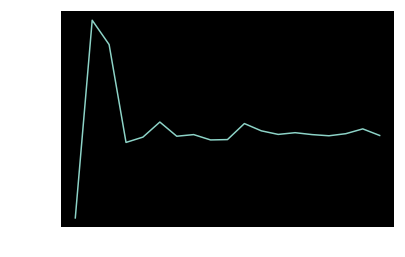

In [268]:
plt.plot()

Text(0, 0.5, 'wavefront error of OPD $[\\mu m]$')

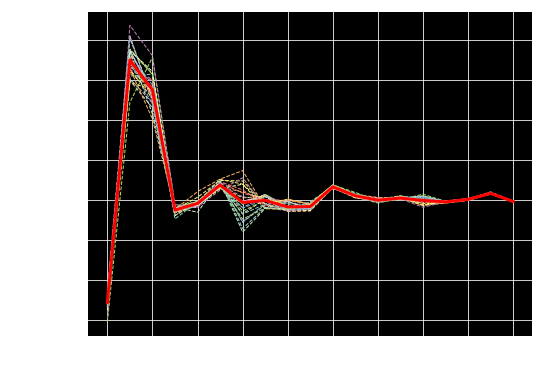

In [280]:
from matplotlib.ticker import MaxNLocator
fig,ax = plt.subplots(1,1,figsize=(8,6))
# to compare the two, need  to somehow "average" the OPD ? 
# plot the values of zernikes at different field points...
for i in range(np.shape(opdData)[0]):
    ax.plot(opdData[i,:], lw=1,ls='--')
# plot the average of these ... 
ax.plot(np.mean(opdData, axis=0), lw=3,ls='-' ,c='r')

ax.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Zernike #')
ax.set_ylabel('wavefront error of OPD '+r'$[\mu m]$')

Plot below the comparison to the mean OPD ... That may not be ideal

   a) because OPD was evaluated at 31 field points while the wavefront error at 4 corner sensors

b) because this is iter0, with noPert - need to run more iterations to check that the FWHM converges 

Text(0.5, 1.0, 'Zernike Errors WFS corner sensors arrows')

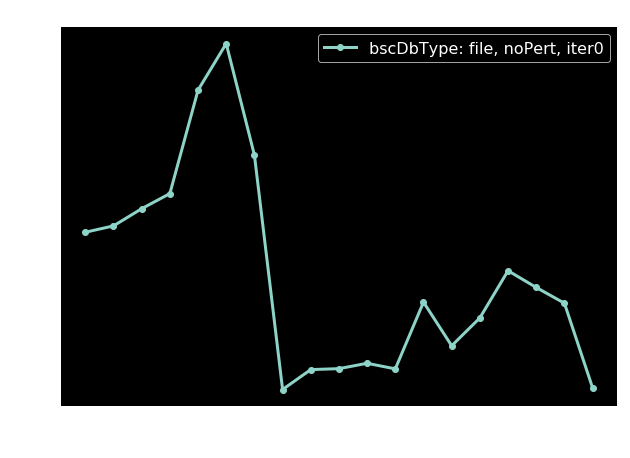

In [283]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# do the difference with mean OPD ... 
meanOpdData = np.mean(opdData, axis=0)
zernikeErrorsDiff = np.sqrt((wfsData0 - meanOpdData)**2.)
# zernikeErrors1 = np.sqrt((wfsData1 - opdData)**2.)
# zernikeErrors2 = np.sqrt((wfsData2 - opdData)**2.)
# zernikeErrors3 = np.sqrt((wfsData3 - opdData)**2.)

zernikeErrors = np.transpose(zernikeErrorsDiff, axes=(1,0))
# zernikeErrors1 = np.transpose(zernikeErrors1, axes=(1,0))
# zernikeErrors2 = np.transpose(zernikeErrors2, axes=(1,0))
# zernikeErrors3 = np.transpose(zernikeErrors3, axes=(1,0))

zernikeRms = np.sqrt(np.mean(np.square(zernikeErrors), axis=1))
# zernikeRms1 = np.sqrt(np.mean(np.square(zernikeErrors1), axis=1))
# zernikeRms2 = np.sqrt(np.mean(np.square(zernikeErrors2), axis=1))
# zernikeRms3 = np.sqrt(np.mean(np.square(zernikeErrors3), axis=1))

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.arange(19)+4, zernikeRms, 
              '-o', lw=3, label='bscDbType: file, noPert, iter0')
# ax.plot(np.arange(19)+4, zernikeRms1, 
#              '-o', lw=3, label='bscDbType: image, new ISR')
# ax.plot(np.arange(19)+4, zernikeRms2, 
#              '-o', lw=3, label='bscDbType: refCat, new ISR')
# ax.plot(np.arange(19)+4, zernikeRms3, 
#              '-o', lw=3, label='bscDbType: new refCat, new ISR')
ax.set_xlabel('Zernike Number', size=18)
ax.set_ylabel('RMS WFS vs OPD (microns)', size=18)

ax.legend(fontsize=16)
ax.set_title('Zernike Errors WFS corner sensors arrows', size=18)


## Multiple iterations  : AOS loop

Rerun the whole LsstCam loop :
    
    source /epyc/users/suberlak/Commissioning/aos/setup_aos_2020_24.sh 
    python runWfsStar.py 
    
    

Show multiple iterations : 

In [308]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert_iters/'
opdDataDic = {}
wfsDataDic = {}
for iterCount in np.arange(4):
    opdZkFilePath = os.path.join(data_dir,  'iter%d/img/opd.zer.wfs'%iterCount)
    opdData = np.loadtxt(opdZkFilePath)
    opdDataDic[iterCount] = opdData

    # show the bscDbType: file results for iter0 with no pert ... 
    wfsZkFilePath = os.path.join(data_dir,  'iter%d/img/wfs.zer.wfs'%iterCount)
    wfsData = np.loadtxt(wfsZkFilePath)
    wfsDataDic[iterCount] = wfsData



OPDs are identical:

Text(0, 0.5, 'wavefront error of OPD $[\\mu m]$')

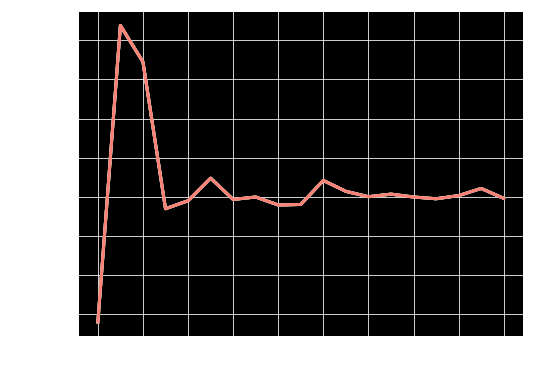

In [316]:
from matplotlib.ticker import MaxNLocator
fig,ax = plt.subplots(1,1,figsize=(8,6))
# to compare the two, need  to somehow "average" the OPD ? 
# plot the values of zernikes at different field points...
for iterCount in range(4):
    opdData = opdDataDic[iterCount]
#     for i in range(np.shape(opdData)[0]):
#         ax.plot(opdData[i,:], lw=1,ls='--')
    # plot the average of these ... 
    ax.plot(np.mean(opdData, axis=0), lw=3,ls='-' ,)

ax.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Zernike #')
ax.set_ylabel('wavefront error of OPD '+r'$[\mu m]$')

### Wavefront errors:

Text(0.5, 1.0, 'Zernike Errors WFS corner sensors arrows')

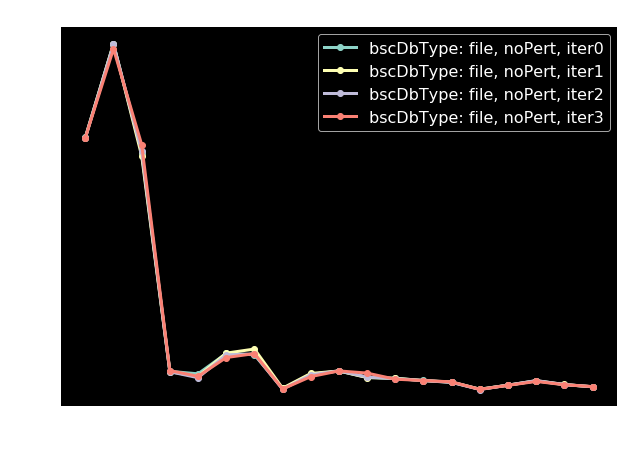

In [318]:
fig,ax = plt.subplots(1,1,figsize=(10,7))

for iterCount in range(4):
    wfsData = wfsDataDic[iterCount]
    opdData = opdDataDic[iterCount]
    # do the difference with mean OPD ... 
    meanOpdData = np.mean(opdData, axis=0)
    zernikeErrorsDiff = np.sqrt((wfsData - meanOpdData)**2.)

    zernikeErrors = np.transpose(zernikeErrorsDiff, axes=(1,0))

    zernikeRms = np.sqrt(np.mean(np.square(zernikeErrors), axis=1))

    ax.plot(np.arange(19)+4, zernikeRms, 
                  '-o', lw=3, label='bscDbType: file, noPert, iter%d'%iterCount)

ax.set_xlabel('Zernike Number', size=18)
ax.set_ylabel('RMS WFS vs OPD (microns)', size=18)

ax.legend(fontsize=16)
ax.set_title('Zernike Errors WFS corner sensors arrows', size=18)


### PSSN and FWHM data: 

In [319]:
pssn_data = []
fwhm_data = []
num_iters=4
for iterNum in range(num_iters):
    pssn_filename = os.path.join(data_dir, 'iter%i' % iterNum, 'img/PSSN.txt')
    pssn_file_array = np.genfromtxt(pssn_filename)
    pssn_data.append(pssn_file_array[0])
    fwhm_data.append(pssn_file_array[1])
pssn_data = np.array(pssn_data)
fwhm_data = np.array(fwhm_data)

(array([0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66]),
 <a list of 8 Text yticklabel objects>)

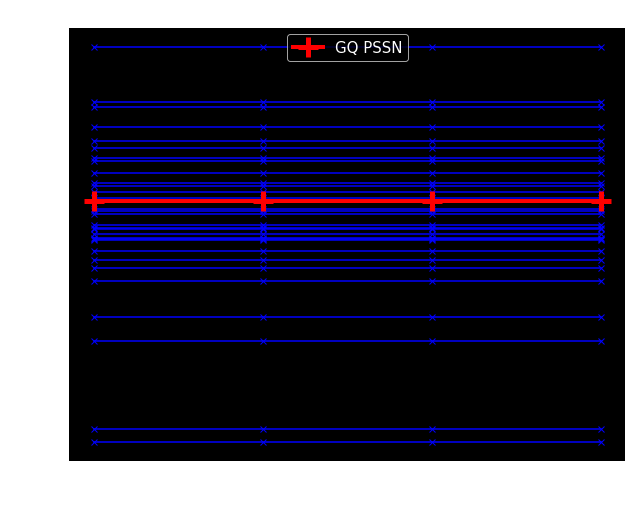

In [321]:
fig = plt.figure(figsize=(10, 8))
num_ccds = 31
for i in range(num_ccds):
    plt.plot(np.arange(num_iters), pssn_data[:,i], c='b', marker='x')
plt.plot(np.arange(num_iters), pssn_data[:,num_ccds], lw=4, marker='+',
         ms=20, markeredgewidth=5, c='r', label='GQ PSSN')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('PSSN')
plt.title('PSSN')
plt.xticks(size=14)
plt.yticks(size=14)

(array([0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62]),
 <a list of 9 Text yticklabel objects>)

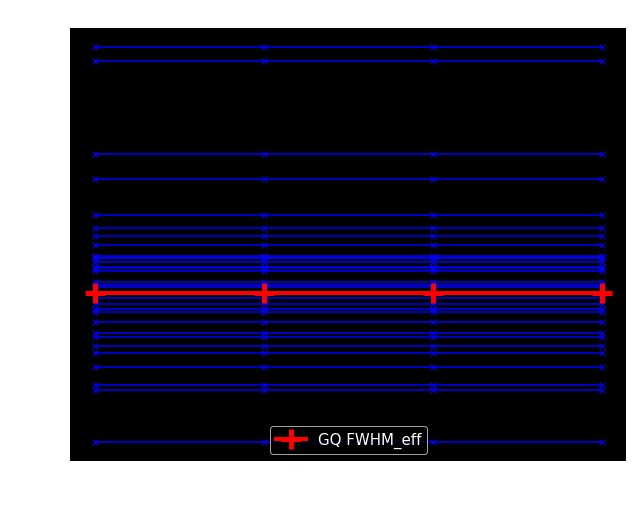

In [322]:
fig = plt.figure(figsize=(10, 8))
num_ccds = 31
for i in range(num_ccds):
    plt.plot(np.arange(num_iters), fwhm_data[:,i], c='b', marker='x')
plt.plot(np.arange(num_iters), fwhm_data[:,num_ccds], lw=4, marker='+',
         ms=20, markeredgewidth=5, c='r', label='GQ FWHM_eff')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('FWHM_eff (arcseconds)')
plt.title('FWHM_eff')
plt.xticks(size=14)
plt.yticks(size=14)

In [325]:
al = ['av']
for a in al:
    print(a)

av
